In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputed_data = pd.read_csv("sbux_clv_drop_AOV_and_completed_offers_across_channels_with_dummies.csv")

# Prepare the data
X = imputed_data[['MemberSince',
       'Recency (# Days ago from last trans. As of final day up to Day 15)',
       'Frequency (# Trans. from Day 1-15)',
       'Monetary Value (Sum of Trans. from Day 1-15)',
       '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
       '# of Marketing offers that were viewed from Day 1-15',
       '# of Marketing offers that were successfully completed from Day 1-15',
       'Marketing Offer View Rate from Day 1-15',
       'Marketing Offer Response Rate from Day 1-15',
       'Age_18-34', 'Age_35-50', 'Age_51-67',
       'Age_68-84', 'Age_85-101', 'Gender_F', 'Gender_M',#'Age_Unknown',
       'Gender_O', 'HH Income_100k-120k',#'Gender_Unknown','HH Income_Unknown'
       'HH Income_30k-50k', 'HH Income_50k-75k', 'HH Income_75k-100k']]

y = imputed_data['Sum(Trans. Amt from Day 16-30)']

# Define the models
mlr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
svr = SVR()
lgbm = LGBMRegressor()
mlp = MLPRegressor()
kr = KernelRidge()

# Define base estimators to be used in the ensemble
base_estimators = [('rf', RandomForestRegressor()),
                   ('xgb', XGBRegressor()),
                   ('dt', DecisionTreeRegressor())]

# Define a final estimator to combine the predictions of the base estimators
final_estimator = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                 ('lasso', LassoCV())])

# Define a StackingRegressor object with the base and final estimator
stacked = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)

# Define the models dictionary
models = {'MLR': mlr, 'Ridge': ridge, 'Lasso': lasso, 'Elastic Net': elastic, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb, 'SVR': svr, 'Stacked Ensemble': stacked, 'LGBM':lgbm, 'MLP':mlp, 'Kernel Ridge': kr}

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Define a function to calculate MAPE while excluding zeros
def mape_exclude_zeros(y_true, y_pred):
    mask = (y_true != 0) & (y_pred != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define an empty dictionary to store the metrics for each model
metrics_dict = {}

best_model = None
best_mape = np.inf

# Iterate over the models
for name, model in tqdm(models.items(), desc="Processing models"):
    metrics_dict[name] = []

    # Exclude y_train=0 and y_pred=0 for MAPE Train
    mask_train = (y_train != 0)
    X_train_filtered = X_train[mask_train]
    y_train_filtered = y_train[mask_train]

    # Exclude y_test=0 and y_pred=0 for MAPE Test
    mask_test = (y_test != 0)
    X_test_filtered = X_test[mask_test]
    y_test_filtered = y_test[mask_test]

    # Evaluate the model using cross-validation on the filtered training set
    mape_train = -cross_val_score(model, X_train_filtered, y_train_filtered, cv=cv, scoring='neg_mean_absolute_percentage_error') * 100

    # Evaluate the model on the filtered test set
    model.fit(X_train_filtered, y_train_filtered)
    y_pred_test = model.predict(X_test_filtered)
    mape_test = mape_exclude_zeros(y_test_filtered, y_pred_test)

    metrics_dict[name].extend([mape_train.mean(), mape_test])

    # Check if the current model has the lowest MAPE Test
    if mape_test < best_mape:
        best_mape = mape_test
        best_model = name

# Create a DataFrame and print the results
metrics_df = pd.DataFrame(metrics_dict, index=['MAPE Train', 'MAPE Test']).T
metrics_df.index.name = 'Model'
print(metrics_df.to_string())

# Print the best model that minimizes MAPE Test
print(f"\nBest Model (minimizing MAPE Test Percentage): {best_model}")

Processing models: 100%|███████████████████████████████████████████████████████████████| 12/12 [05:38<00:00, 28.21s/it]

                  MAPE Train   MAPE Test
Model                                   
MLR               201.692416  222.830876
Ridge             200.318311  223.013428
Lasso             261.935369  335.184635
Elastic Net       344.445497  460.316027
Decision Tree     191.382039  235.378651
Random Forest     165.802525  188.974462
XGBoost           156.810665  186.661080
SVR               293.580365  389.968433
Stacked Ensemble  242.654360  310.766496
LGBM              159.833102  179.326310
MLP               233.784331  306.457228
Kernel Ridge      215.416364  246.414024

Best Model (minimizing MAPE Test Percentage): LGBM


Processing models: 100%|███████████████████████████████████████████████████████████████| 12/12 [06:34<00:00, 32.86s/it]


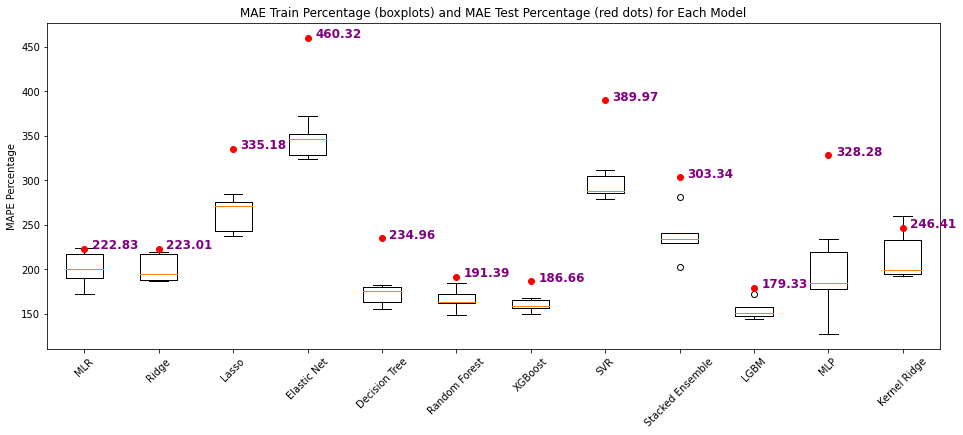

The best performing model is LGBM, with a MAPE Test Percentage of 179.33.


In [2]:
fig, ax = plt.subplots(figsize=(16, 6))

# Create lists to store the MAPE train and test values for each model
mape_train_values = []
mape_test_values = []

# Iterate over the models
for name, model in tqdm(models.items(), desc="Processing models"):

    # Exclude y_train=0 and y_pred=0 for MAPE Train
    mask_train = (y_train != 0)
    X_train_filtered = X_train[mask_train]
    y_train_filtered = y_train[mask_train]

    # Exclude y_test=0 and y_pred=0 for MAPE Test
    mask_test = (y_test != 0)
    X_test_filtered = X_test[mask_test]
    y_test_filtered = y_test[mask_test]

    # Evaluate the model using cross-validation on the filtered training set
    mape_train = -cross_val_score(model, X_train_filtered, y_train_filtered, cv=cv, scoring='neg_mean_absolute_percentage_error') * 100

    # Evaluate the model on the filtered test set
    model.fit(X_train_filtered, y_train_filtered)
    y_pred_test = model.predict(X_test_filtered)
    mape_test = mape_exclude_zeros(y_test_filtered, y_pred_test)

    # Append MAPE train and test values to the respective lists
    mape_train_values.append(mape_train)
    mape_test_values.append(mape_test)

# Boxplot of MAPE Train values for each model
bp = ax.boxplot(mape_train_values, labels=list(models.keys()))

# Set the label of the y-axis
ax.set_ylabel('MAPE Percentage')

# Set the title of the plot
ax.set_title('MAE Train Percentage (boxplots) and MAE Test Percentage (red dots) for Each Model')
# Plot a red dot of the MAPE Test value
for i, mape_test in enumerate(mape_test_values):
    ax.plot(i + 1, mape_test, 'ro')
    ax.annotate(f'{mape_test:.2f}', (i + 1.1, mape_test), fontsize=12, color='purple', fontweight='bold')

# Set the x-ticks to the model names
plt.xticks(np.arange(1, len(models) + 1), list(models.keys()), rotation=45)

# Show the plot
plt.show()

best_model = metrics_df['MAPE Test'].idxmin()
best_mape = metrics_df.loc[best_model, 'MAPE Test']

print(f'The best performing model is {best_model}, with a MAPE Test Percentage of {best_mape:.2f}.')


Best performing model based on lowest MAPE Test Percentage: LGBM (MAPE=179.33)%


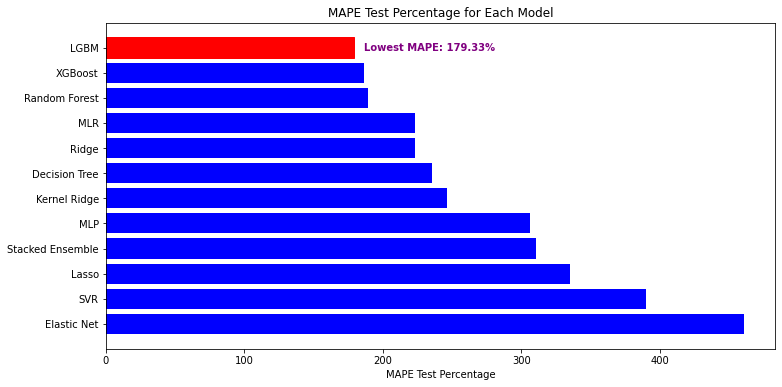

In [3]:
# Find the model with the lowest MAE
min_mae_model = metrics_df['MAPE Test'].idxmin()
min_mae_value = metrics_df.loc[min_mae_model, 'MAPE Test']

print(f"Best performing model based on lowest MAPE Test Percentage: {min_mae_model} (MAPE={min_mae_value:.2f})%")

# Sort the DataFrame by MAPE Test values in ascending order
sorted_df = metrics_df.sort_values(by='MAPE Test')

# Create a horizontal bar chart to visualize the MAE Test values for each model
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(sorted_df.index, sorted_df['MAPE Test'].values, color='blue')

# Highlight the best performing model with a different color
bars[sorted_df.index.get_loc(min_mae_model)].set_color('red')

# Annotate the best performing model
ax.annotate(f"Lowest MAPE: {min_mae_value:.2f}%",
            xy=(min_mae_value, min_mae_model),
            xytext=(10, 0), textcoords='offset points',
            ha='left', va='center',
            color='purple', fontweight='bold')

# Set the label of the x-axis
ax.set_xlabel('MAPE Test Percentage')

# Set the title of the plot
ax.set_title('MAPE Test Percentage for Each Model')

# Invert the y-axis to show the models in descending order
ax.invert_yaxis()

# Show the plot
plt.show()
